# OCT Image Registration Test with Single Frame

## Setup

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from scipy import ndimage

In [6]:
from scipy.ndimage import map_coordinates

In [4]:
DATA_DIR = 'data/BL'

## Load grayscale image

In [101]:
img = np.load(os.path.join(DATA_DIR, 'centered_image.npy'))

In [102]:
img.shape

(1024, 1024, 541, 3)

In [103]:
img = np.linalg.norm(img, axis=3)

In [104]:
img.shape

(1024, 1024, 541)

In [15]:
# run if needed
# np.save(os.path.join(DATA_DIR, 'centered_image_gray.npy'), img)

In [105]:
# test with only first frame
img = img[250:750,250:750,0]

In [106]:
img = (img - img.min()) / (img.max() - img.min())

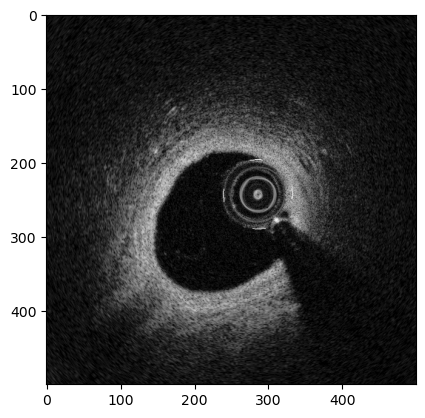

In [107]:
plt.imshow(img, cmap='Grays_r')

## Gradient descent functions

In [16]:
def rotation_matrix(theta):
    return np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])

In [17]:
def rotation_matrix_derivative(theta):
    return np.array([
        [-np.sin(theta), -np.cos(theta)],
        [np.cos(theta), -np.sin(theta)]
    ])

In [18]:
def rotate_image(theta, image):
    h, w = image.shape

    y, x = np.indices((h, w))
    cx = w/2.0 - 0.5  # because of zero-indexing
    cy = h/2.0 - 0.5
    coords = np.vstack([(x - cx).ravel(), (y - cy).ravel()])

    R = rotation_matrix(theta)
    rotated = R @ coords
    
    x_rot = rotated[0,:] + cx
    y_rot = rotated[1,:] + cy

    I_rot = map_coordinates(image, [y_rot, x_rot], order=1, mode='constant', cval=0.0)
    I_rot = I_rot.reshape(h, w)

    return I_rot

In [19]:
def loss_and_gradient(theta, I_ref, I_mov):
    h, w = I_ref.shape

    y, x = np.indices((h, w))
    cx = w/2.0 - 0.5  # because of zero-indexing
    cy = h/2.0 - 0.5
    coords = np.vstack([(x - cx).ravel(), (y - cy).ravel()])

    R = rotation_matrix(theta)
    Rp = rotation_matrix_derivative(theta)
    rotated = R @ coords

    x_rot = rotated[0,:] + cx
    y_rot = rotated[1,:] + cy

    I_mov_rot = map_coordinates(I_mov, [y_rot, x_rot], order=1, mode='constant', cval=0.0)
    I_mov_rot = I_mov_rot.reshape(h, w)

    grad_y, grad_x = np.gradient(I_mov)

    gx = map_coordinates(grad_x, [y_rot, x_rot], order=1, mode='constant', cval=0.0)
    gy = map_coordinates(grad_y, [y_rot, x_rot], order=1, mode='constant', cval=0.0)

    N = I_ref.shape[0] * I_ref.shape[1]
    diff = I_mov_rot - I_ref
    loss = np.sum(diff**2) / N

    Rp_coords = Rp @ coords
    dxdtheta = Rp_coords[0,:]
    dydtheta = Rp_coords[1,:]

    grad_term = gx * dxdtheta + gy * dydtheta
    dloss = 2.0/N * np.sum(diff.ravel() * grad_term)
    
    return loss, dloss

In [128]:
def gradient_descent(theta_init, I_ref, I_mov, step_init=1e-3, max_steps=100, loss_threshold=1e-6, epsilon=1e-8):
    theta = theta_init
    loss, grad = loss_and_gradient(theta, I_ref, I_mov)
    history = [(loss, theta, step_init)]
    accumulated_grad_sq = 0.0

    step_num = 1
    while step_num < max_steps and loss > loss_threshold:
        accumulated_grad_sq += grad**2
        
        step_size = step_init / (np.sqrt(accumulated_grad_sq) + epsilon)
        
        theta -= step_size * grad
        
        loss, grad = loss_and_gradient(theta, I_ref, I_mov)
        history.append((loss, theta, step_size))
        
        step_num += 1

    success = loss <= loss_threshold

    return history, theta, success

## Test

In [108]:
rotated_img = rotate_image(np.pi/2, img)

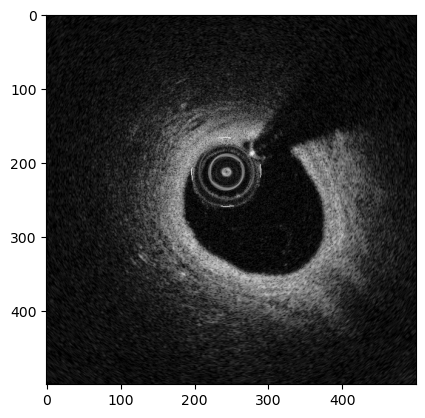

In [109]:
plt.imshow(rotated_img, cmap='Grays_r')

In [110]:
np.pi/2

1.5707963267948966

In [129]:
history, theta, success = gradient_descent(-0.1, img, rotated_img, step_init=0.4)

In [131]:
success

np.False_

In [133]:
history_arr = np.array(history)

In [137]:
import matplotlib

In [150]:
matplotlib.rcParams.update({'font.size': 30})

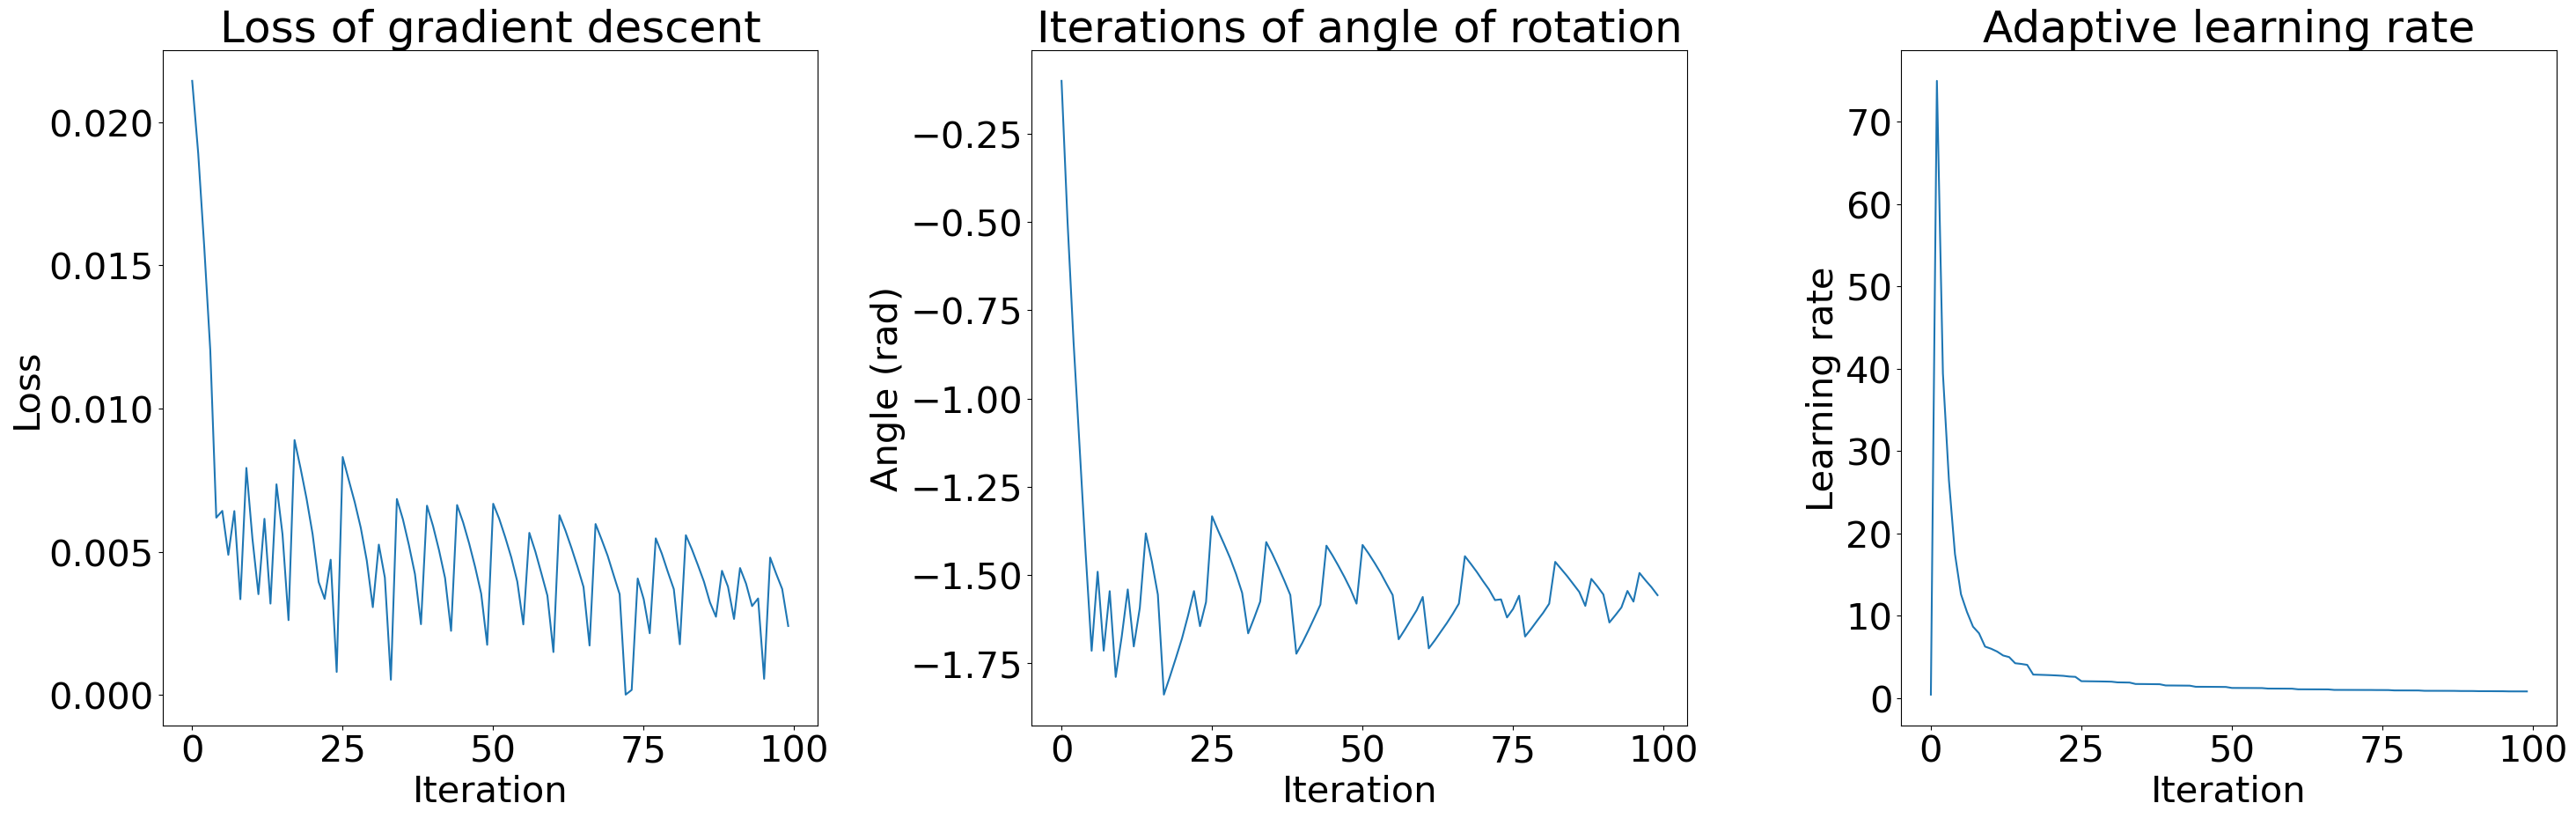

In [153]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].plot(history_arr[:,0])
axes[0].set_title('Loss of gradient descent')
axes[0].set_xlabel('Iteration')
axes[0].set_ylabel('Loss')

axes[1].plot(history_arr[:,1])
axes[1].set_title('Iterations of angle of rotation')
axes[1].set_xlabel('Iteration')
axes[1].set_ylabel('Angle (rad)')

axes[2].plot(history_arr[:,2])
axes[2].set_title('Adaptive learning rate')
axes[2].set_xlabel('Iteration')
axes[2].set_ylabel('Learning rate')

plt.tight_layout()
fig.savefig('grad_desc_history')

In [42]:
success

np.False_

In [120]:
theta_final = history_arr[np.argmin(history_arr[:,0]), 1]

In [124]:
final_image = rotate_image(theta_final, rotated_img)

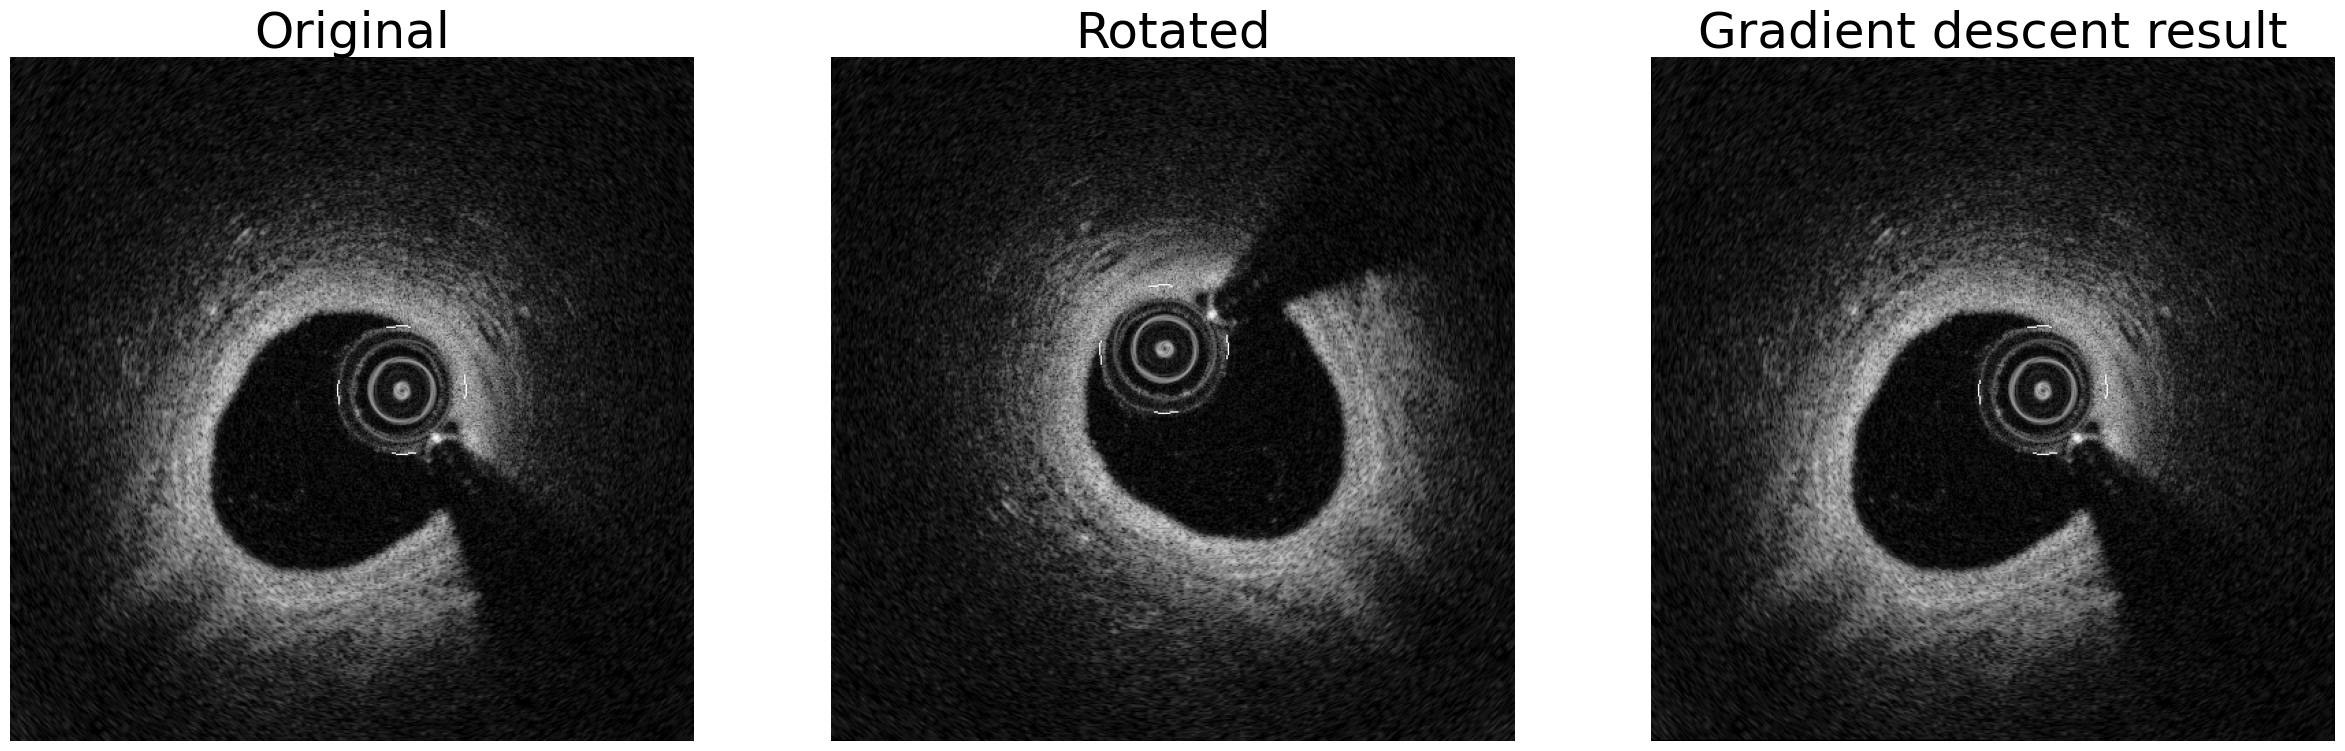

In [152]:
fig, axes = plt.subplots(1, 3, figsize=(30, 10))

axes[0].imshow(img, cmap='Grays_r')
axes[0].set_title('Original')
axes[0].set_axis_off()

axes[1].imshow(rotated_img, cmap='Grays_r')
axes[1].set_title('Rotated')
axes[1].set_axis_off()

axes[2].imshow(final_image, cmap='Grays_r')
axes[2].set_title('Gradient descent result')
axes[2].set_axis_off()

plt.savefig('registration_example')